In [139]:
import json
import requests
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import re
%matplotlib inline

# Reading from link_data

In [140]:
def data_to_df(link):
    filename = 'time-series-prediction/link_data/' + str(link) + '.txt'
    with open(filename) as f:
        data = json.load(f)
    df = pd.DataFrame(data['points'], columns=['Time', 'In', 'Out'])
    return df

In [141]:
#loading data
df_sacr_denv = data_to_df('sacr_denv')
df_denv_kans = data_to_df('denv_kans')
df_star_aofa = data_to_df('star_aofa')
df_aofa_lond_721 = data_to_df('aofa_lond-7-2-1')
df_aofa_lond_211 = data_to_df('aofa_lond-2-1-1')

#combine aofa_lond dataframes by summing columns
df_aofa_lond = pd.DataFrame()
df_aofa_lond['Time'] = df_aofa_lond_721['Time']
df_aofa_lond['In'] = df_aofa_lond_721['In'] + df_aofa_lond_211['In']
df_aofa_lond['Out'] = df_aofa_lond_721['Out'] + df_aofa_lond_211['Out']

In [142]:
df_aofa_lond.head()

,Time,In,Out
0,1539648000000,4.083497e+10,6.904156e+10
1,1539651600000,4.579987e+10,7.620594e+10
2,1539655200000,4.247330e+10,6.759717e+10
3,1539658800000,3.547334e+10,6.205643e+10
4,1539662400000,3.629468e+10,6.676883e+10


In [152]:
df_sacr_denv = df_sacr_denv.dropna()
df_denv_kans = df_denv_kans.dropna()
df_star_aofa = df_star_aofa.dropna()
df_aofa_lond = df_aofa_lond.dropna()

# Reading from link_data_cleaned

In [533]:
df_sacr_denv = pd.read_csv('time-series-prediction/link_data_cleaned/sacr_denv_out.csv', header=None)
df_sacr_denv = df_sacr_denv.rename(columns = {0: "Time", 
                                  1:"Out"}) 

df_denv_kans = pd.read_csv('time-series-prediction/link_data_cleaned/denv_kans_in.csv', header=None)
df_denv_kans = df_denv_kans.rename(columns = {0: "Time", 
                                  1:"In"}) 

df_star_aofa = pd.read_csv('time-series-prediction/link_data_cleaned/star_aofa_in.csv', header=None)
df_star_aofa = df_star_aofa.rename(columns = {0: "Time", 
                                  1:"In"}) 

df_aofa_lond = pd.read_csv('time-series-prediction/link_data_cleaned/aofa_lond_out.csv', header=None)
df_aofa_lond = df_aofa_lond.rename(columns = {0: "Time", 
                                  1:"Out"}) 

In [534]:
df_sacr_denv.head()

,Time,Out
0,2018-10-16 00:00:00,2.342205e+10
1,2018-10-16 01:00:00,2.116059e+10
2,2018-10-16 02:00:00,2.031477e+10
3,2018-10-16 03:00:00,2.548832e+10
4,2018-10-16 04:00:00,1.955298e+10


In [22]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, model_from_json, Model
from keras.layers import Dense, LSTM, Activation, Dropout, Bidirectional, TimeDistributed, RepeatVector, Input, GRU, Lambda
#from keras.utils.vis_utils import plot_model
from keras.optimizers import SGD
#from keras.utils import multi_gpu_model
import keras
from random import uniform
import json
# Fix AttributeError: 'module' object has no attribute 'control_flow_ops'
import tensorflow
from tensorflow.python.ops import control_flow_ops
tensorflow.control_flow_ops = control_flow_ops

Using TensorFlow backend.


In [237]:
def inverse_transform(pred, traffic_scaler):    
    return traffic_scaler.inverse_transform(pred)

def graph_results(model, X_test, Y_test, traffic_scaler, batch_size = 1):
    # walk-forward validation on the test data
    pred_x_test = model.predict(X_test, batch_size)
    pred_test = inverse_transform(pred_x_test, traffic_scaler)

    y_test = np.float_(Y_test)
    y_test_inv = inverse_transform(y_test, traffic_scaler)

    line_test_pred = np.reshape(pred_test, pred_test.shape[0])
    line_test_real = np.reshape(y_test_inv, y_test_inv.shape[0])
    plt.figure(figsize=(20,10))
    plt.plot(line_test_real, color='blue',label='Original', linewidth=1)
    plt.plot(line_test_pred, color='red',label='Prediction', linewidth=1)
    plt.legend(loc='best')
    plt.title('Test - Comparison')
    plt.show()

def train_val_predictions(model, X_train, Y_train, X_val, Y_val):
    X_train_pred = model.predict(X_train, batch_size)
    #X_train_pred_inv = inverse_transform(X_train_pred, scaler)

    X_val_pred = model.predict(X_val, batch_size)
    #X_val_pred_inv = inverse_transform(X_val_pred, scaler)

    y_train = np.float_(Y_train)
    #y_train_inv = inverse_transform(y_train, scaler)

    y_val = np.float_(Y_val)
    #y_val_inv = inverse_transform(y_val, traffic_scaler)

    total_truth = np.vstack((y_train, y_val))
    total_pred = np.vstack((X_train_pred, X_val_pred))
    
    return total_truth, total_pred

In [61]:
def train_test_aggregated_addfeatures(df, seq_len_x, seq_len_y, scaler, print_shapes = True):
    
    #indices = [i for i, s in enumerate(list(df.columns.values)) if pathway in s]
    #vals_indices = [i for i, s in enumerate(list(df.columns.values)) if "val" in s][10:]
    
    #indices_total = indices + vals_indices
    
    #X = df.iloc[:,indices].as_matrix()
    X = df.iloc[:,1].as_matrix()
    X = scaler.fit_transform(X)
    
    result_X = []
    result_Y = []

    for index in range(0, X.shape[0] - (seq_len_x + seq_len_y + 1), seq_len_x + seq_len_y):
        result_X.append(X[index: index + seq_len_x]) 
        result_Y.append(X[index + seq_len_x: index + seq_len_x + seq_len_y])

    result_X = np.array(result_X)
    result_Y = np.array(result_Y)

    X_train = result_X[:118]
    Y_train = result_Y[:118]
    X_val = result_X[118:]
    Y_val = result_Y[118:]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

    Y_train = np.reshape(Y_train, (Y_train.shape[0], Y_train.shape[1], 1))
    Y_val = np.reshape(Y_val, (Y_val.shape[0], Y_val.shape[1], 1))

    if print_shapes:
        print("X_train shape: ", X_train.shape)
        print("Y_train shape: ", Y_train.shape)
        print("X_val shape: ", X_val.shape)
        print("Y_val shape: ", Y_val.shape)
    
    return scaler, X_train, Y_train, X_val, Y_val

In [87]:
batch_size = 1
nb_epoch = 30

model_aggregated = Sequential()
model_aggregated.add(LSTM(input_dim = 1, output_dim=10, return_sequences=False))
model_aggregated.add(Dropout(0.2))
model_aggregated.add(RepeatVector(8)) #seq_len_y
model_aggregated.add(LSTM(output_dim=8, return_sequences=True))
model_aggregated.add(Dropout(0.2))
model_aggregated.add(TimeDistributed(Dense(1))) 

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=10, return_sequences=False, input_shape=(None, 1))`
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=8, return_sequences=True)`


In [88]:
print("-- Building --")
model_aggregated.compile(loss="mse",
                  optimizer = 'adam')

print('-- Training --')
for i in range(nb_epoch):
    model_aggregated.fit(X_train, Y_train, epochs=1, batch_size=batch_size, validation_data = (X_val, Y_val), 
                         shuffle=True)
    model_aggregated.reset_states()

-- Building --
-- Training --


ValueError: Error when checking target: expected time_distributed_5 to have 3 dimensions, but got array with shape (2136, 1)

In [73]:
# walk-forward validation on the test data
pred_x_test = model_aggregated.predict(X_val, batch_size)
print(pred_x_test.shape)
#pred_x_test = np.reshape(pred_x_test, (pred_x_test.shape[0]*pred_x_test.shape[1], 36))
#pred_test = inverse_transform(pred_x_test, scaler)

y_test = np.float_(Y_val)
#y_test = np.reshape(y_test, (y_test.shape[0]*y_test.shape[1], 36))
#y_test_inv = inverse_transform(y_test, scaler)

(1, 8, 1)


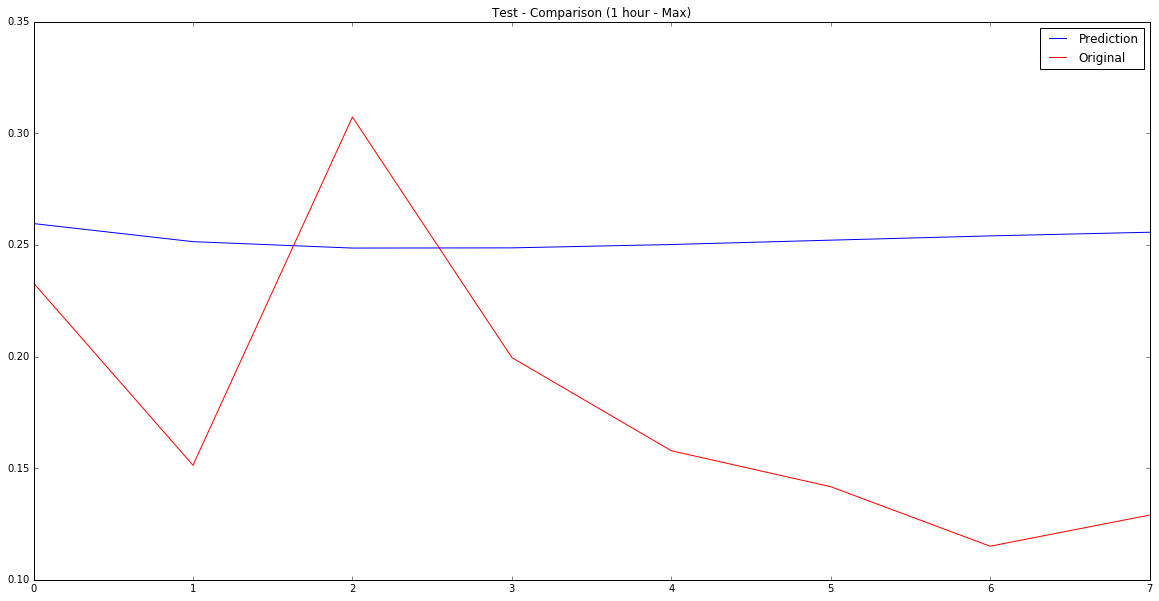

In [79]:
#1 timestep ahead has good prediction

pred_first = [item[1] for item in pred_x_test]
#pred_first_first = [item[1] for item in pred_first] #0 = min, 1 = max
y_first = [item[1] for item in Y_val]
#y_first_first = [item[1] for item in y_first] #0 = min, 1 = max


# line_test_pred = np.reshape(pred_test, pred_test.shape[0])
# line_test_real = np.reshape(y_test_inv, y_test_inv.shape[0])
plt.figure(figsize=(20,10))
plt.plot(pred_x_test.reshape(8,1), color='blue',label='Prediction', linewidth=1)
plt.plot(Y_val.reshape(8,1), color='red',label='Original', linewidth=1)
plt.legend(loc='best')
plt.title('Test - Comparison (1 hour - Max)')
plt.show()

In [471]:
def train_test_wfeatures(df, scaler, traffic_scaler, print_shapes = True):
    """Returns training and test data from Pandas DataFrame of data

    Args:
        df (DataFrame): A Pandas DataFrame containing the data for one site to another site
                        the dataframe should contain time, features (ex. Day, Month, Weekend) 
                        and the response variable.
        pathway (str): The names of the two sites separated by a double dash (ex. "CHIC--STAR")
        split_proportion (float): Proportion (from 0 to 1) of data to be allocated to training data
        scaler (MinMaxScaler): scaler for features
        traffic_scaler (MinMaxScaler): scaler for response variable
        print_shapes (bool): True (default) to print shapes of the training and test data
                             False to turn off printing
        
        """
    
    #Split features from response variable
    X = df.iloc[:,1].as_matrix() #drop time to get all features
    Y = df.iloc[:,1].shift(1).fillna(0).as_matrix() #shift traffic values down 1 to create response variable

    #Normalize
    X = scaler.fit_transform(X)
    Y = traffic_scaler.fit_transform(Y)

    #reshape to [samples, features, timesteps]
    X = X.reshape(X.shape[0], 1, 1)
    Y = Y.reshape(Y.shape[0], 1)

    #Train-test split
    X_train = X[:2136]
    Y_train = Y[:2136]
    X_val = X[2136:]
    Y_val = Y[2136:]
    
    if print_shapes:
        print("X_train shape: ", X_train.shape)
        print("Y_train shape: ", Y_train.shape)
        print("X_val shape: ", X_val.shape)
        print("Y_val shape: ", Y_val.shape)
    
    return scaler, traffic_scaler, X_train, Y_train, X_val, Y_val

# SACR-DENV

In [472]:
scaler = MinMaxScaler(feature_range=(0,1))
traffic_scaler = MinMaxScaler(feature_range=(0,1))
scaler, traffic_scaler, X_train_sacrdenv, Y_train_sacrdenv, X_val_sacrdenv, Y_val_sacrdenv = train_test_wfeatures(
    df_sacr_denv[['Time', 'Out']], scaler, traffic_scaler)

X_train shape:  (2136, 1, 1)
Y_train shape:  (2136, 1)
X_val shape:  (24, 1, 1)
Y_val shape:  (24, 1)


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.w

array([[ 0.35030481]])

In [489]:
nb_epoch = 20
batch_size = 1

train_loss_sacrdenv = []
val_loss_sacrdenv = []

training_sizes = [50, 100, 200, 500, 1000, 2000]
errors_sacrdenv = []

for train_size in training_sizes:
    
    #creating
    model_sacrdenv = Sequential()
    model_sacrdenv.add(LSTM(50, batch_input_shape=(batch_size, 
                                                   X_train_sacrdenv.shape[1], 
                                                   X_train_sacrdenv.shape[2]), 
                                                    stateful=True))
    model_sacrdenv.add(Dense(1))
    
    #building
    model_sacrdenv.compile(loss="mse",
                      optimizer = 'adam',
                    metrics = ['accuracy'])

    #training
    for i in range(nb_epoch):
        history = model_sacrdenv.fit(X_train_sacrdenv[:x], Y_train_sacrdenv[:x], nb_epoch=1, 
                                     batch_size=batch_size, shuffle=False, 
                                     validation_data = (X_val_sacrdenv, Y_val_sacrdenv), verbose = 0)
        model_sacrdenv.reset_states()
        
    error = model_sacrdenv.evaluate(X_train_sacrdenv[train_size + 1].reshape(1,1,1), 
                                    Y_train_sacrdenv[train_size + 1].reshape(1,1), 
                                    verbose=0, batch_size = 1)
    errors_sacrdenv.append(error)

for i in range(nb_epoch):
    
    #creating
    model_sacrdenv = Sequential()
    model_sacrdenv.add(LSTM(50, batch_input_shape=(batch_size, 
                                                   X_train_sacrdenv.shape[1], 
                                                   X_train_sacrdenv.shape[2]), 
                                                    stateful=True))
    model_sacrdenv.add(Dense(1))
    
    #building
    model_sacrdenv.compile(loss="mse",
                      optimizer = 'adam',
                    metrics = ['accuracy'])
    
    #training
    history = model_sacrdenv.fit(X_train_sacrdenv, Y_train_sacrdenv, nb_epoch=1, batch_size=batch_size, shuffle=False, 
                       validation_data = (X_val_sacrdenv, Y_val_sacrdenv), verbose = 0)
    
    train_loss_sacrdenv.append(history.history['loss'])
    val_loss_sacrdenv.append(history.history['val_loss'])
    model_sacrdenv.reset_states()

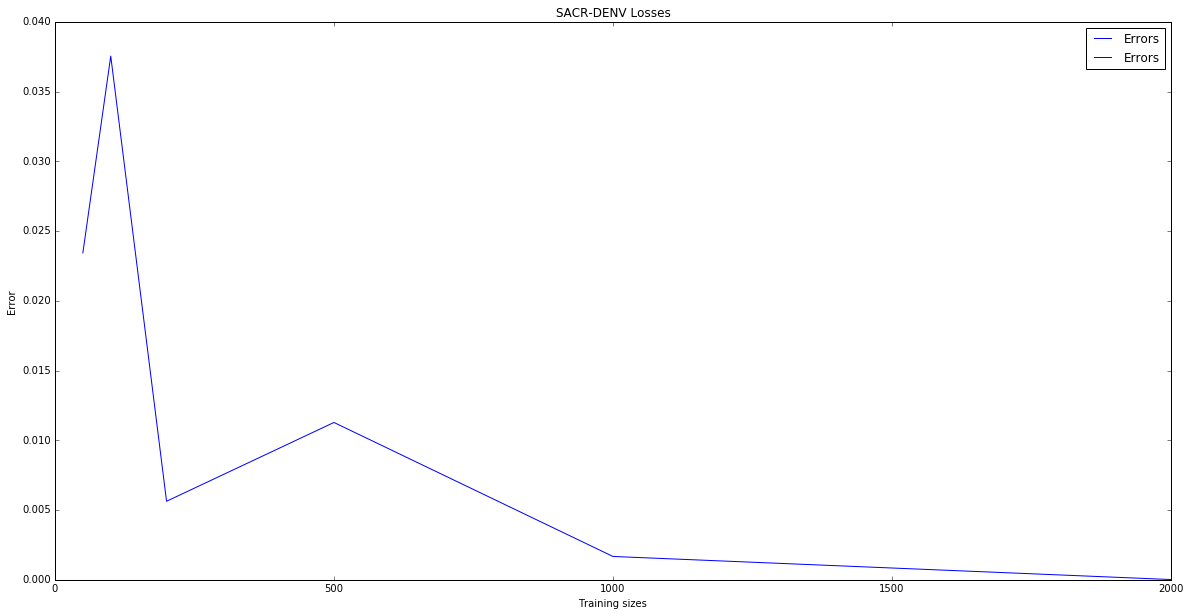

In [491]:
fig1_errors = plt.figure(figsize=(20,10))
plt.plot(training_sizes, errors_sacrdenv, color='blue',label='Errors', linewidth=1)
plt.xlabel("Training sizes")
plt.ylabel("Error")
plt.legend(loc='best')
plt.title('SACR-DENV Losses')
plt.show()

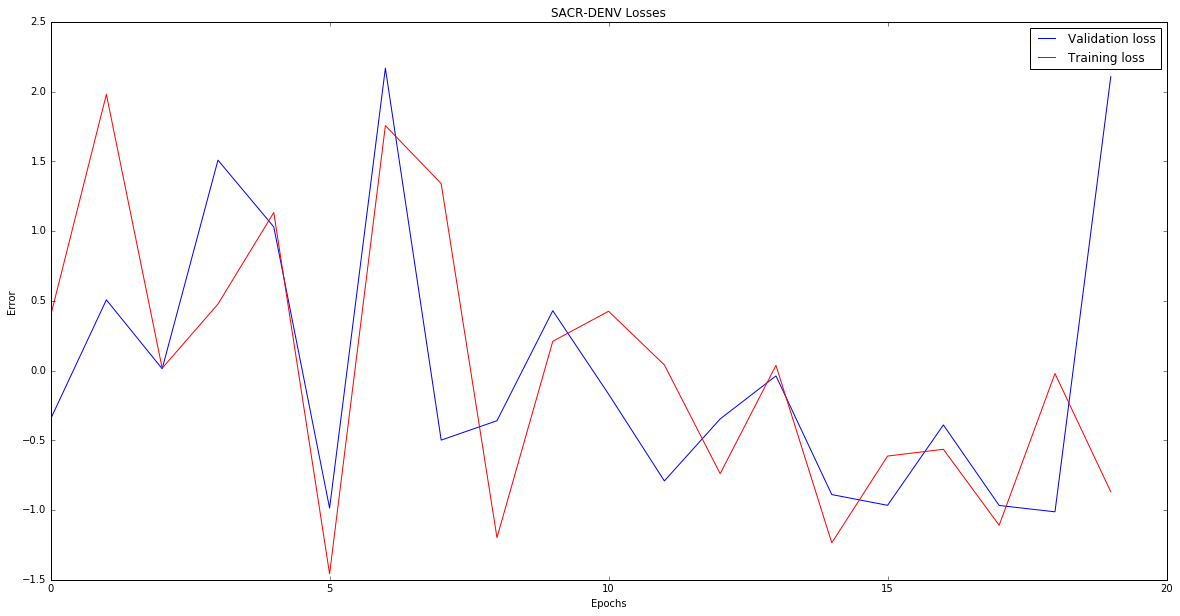

In [492]:
val_loss_reshaped_sacrdenv = np.array(val_loss_sacrdenv).reshape(np.array(val_loss_sacrdenv).shape[0])
train_loss_reshaped_sacrdenv = np.array(train_loss_sacrdenv).reshape(np.array(train_loss_sacrdenv).shape[0])

losses_sacrdenv = pd.DataFrame()
losses_sacrdenv['Train loss'] = train_loss_reshaped_sacrdenv
losses_sacrdenv['Validation loss'] = val_loss_reshaped_sacrdenv

losses_norm_sacrdenv = (losses_sacrdenv - losses_sacrdenv.mean()) / (losses_sacrdenv.std())

fig1_losses = plt.figure(figsize=(20,10))
plt.plot(losses_norm_sacrdenv['Validation loss'], color='blue',label='Validation loss', linewidth=1)
plt.plot(losses_norm_sacrdenv['Train loss'], color='red',label='Training loss', linewidth=1)
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend(loc='best')
plt.title('SACR-DENV Losses')
plt.show()

Test loss: [0.0010315328595614421, 0.0]


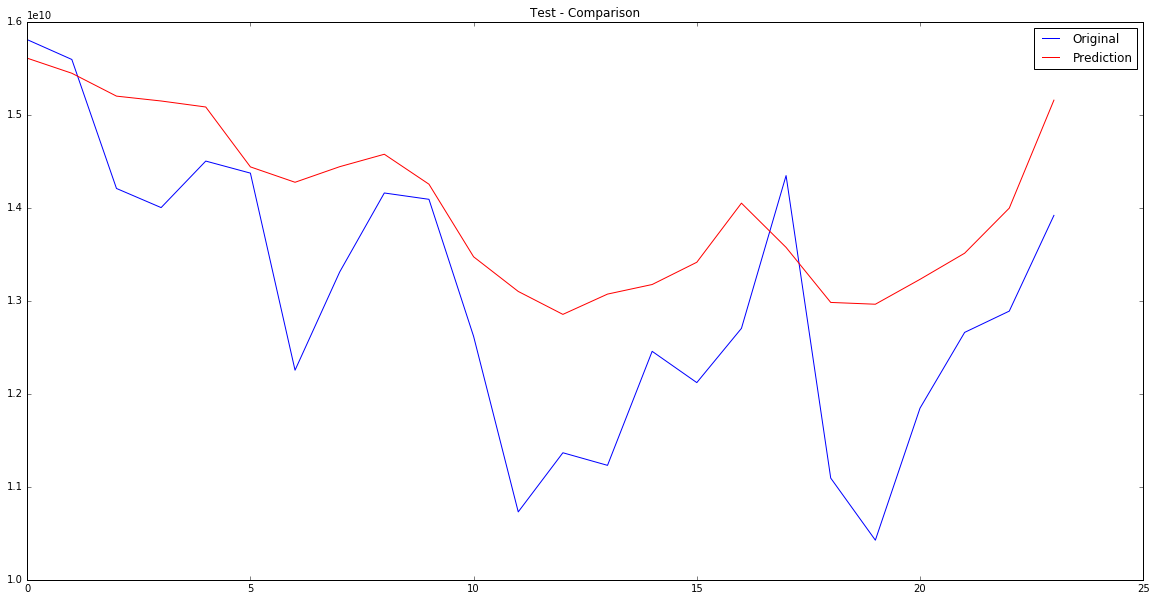

In [510]:
score = model_sacrdenv.evaluate(X_val_sacrdenv, Y_val_sacrdenv, verbose=0, batch_size = 1)
print('Test loss:', score)

graph_results(model_sacrdenv, X_val_sacrdenv, Y_val_sacrdenv, traffic_scaler)

In [511]:
total_truth_sacrdenv, total_pred_sacrdenv = train_val_predictions(model_sacrdenv, X_train_sacrdenv, Y_train_sacrdenv, 
                                                                 X_val_sacrdenv, Y_val_sacrdenv)

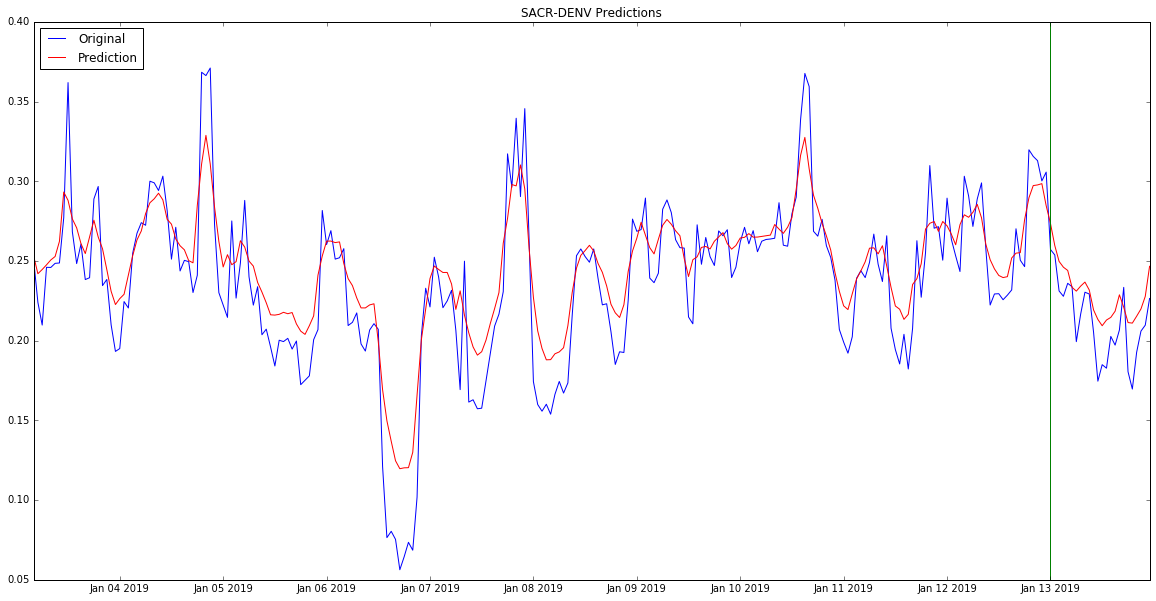

In [517]:
#control how much training data to show
x = 1900

# walk-forward validation on the test data
line_test_pred = np.reshape(total_pred_sacrdenv[x:], total_pred_sacrdenv[x:].shape[0])
line_test_real = np.reshape(total_truth_sacrdenv[x:], total_truth_sacrdenv[x:].shape[0])

#dates for plot
#dates = df_sacr_denv['Time'].apply(lambda x: datetime.fromtimestamp(x/1000.))
dates = df_sacr_denv['Time'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

fig1 = plt.figure(figsize=(20,10))
plt.plot(dates[x:], 
         line_test_real, color='blue',label='Original', linewidth=1)
plt.plot(dates[x:], 
         line_test_pred, color='red',label='Prediction', linewidth=1)
plt.axvline(x=dates[2136], color = 'green')
plt.legend(loc='best')
plt.title('SACR-DENV Predictions')
plt.show()

fig1.savefig('time-series-prediction/sacr-denv.png')

In [519]:
final_preds_sacrdenv_df = pd.DataFrame()
final_preds_sacrdenv_df['Time'] = dates[2136:]
final_preds_sacrdenv_df['Out Prediction'] = total_pred_sacrdenv[2136:]
final_preds_sacrdenv_df.to_csv('time-series-prediction/sacr_denv_pred.csv', sep=',')

# DENV-KANS

In [493]:
scaler = MinMaxScaler(feature_range=(0,1))
traffic_scaler = MinMaxScaler(feature_range=(0,1))
scaler, traffic_scaler, X_train_denvkans, Y_train_denvkans, X_val_denvkans, Y_val_denvkans = train_test_wfeatures(
    df_denv_kans[['Time', 'In']], scaler, traffic_scaler)

X_train shape:  (2136, 1, 1)
Y_train shape:  (2136, 1)
X_val shape:  (24, 1, 1)
Y_val shape:  (24, 1)


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.w

In [494]:
nb_epoch = 20
batch_size = 1

train_loss_denvkans = []
val_loss_denvkans = []

training_sizes = [50, 100, 200, 500, 1000, 2000]
errors_denvkans = []

for train_size in training_sizes:
    
    #creating
    model_denvkans = Sequential()
    model_denvkans.add(LSTM(50, batch_input_shape=(batch_size, 
                                                   X_train_denvkans.shape[1], 
                                                   X_train_denvkans.shape[2]), 
                                                    stateful=True))
    model_denvkans.add(Dense(1))
    
    #building
    model_denvkans.compile(loss="mse",
                      optimizer = 'adam',
                    metrics = ['accuracy'])

    #training
    for i in range(nb_epoch):
        history = model_denvkans.fit(X_train_denvkans[:x], Y_train_denvkans[:x], nb_epoch=1, 
                                     batch_size=batch_size, shuffle=False, 
                                     validation_data = (X_val_denvkans, Y_val_denvkans), verbose = 0)
        model_denvkans.reset_states()
        
    error = model_denvkans.evaluate(X_train_denvkans[train_size + 1].reshape(1,1,1), 
                                    Y_train_denvkans[train_size + 1].reshape(1,1), 
                                    verbose=0, batch_size = 1)
    errors_denvkans.append(error)

for i in range(nb_epoch):
    
    #creating
    model_denvkans = Sequential()
    model_denvkans.add(LSTM(50, batch_input_shape=(batch_size, 
                                                   X_train_denvkans.shape[1], 
                                                   X_train_denvkans.shape[2]), 
                                                    stateful=True))
    model_denvkans.add(Dense(1))
    
    #building
    model_denvkans.compile(loss="mse",
                      optimizer = 'adam',
                    metrics = ['accuracy'])

    #training
    history = model_denvkans.fit(X_train_denvkans, Y_train_denvkans, nb_epoch=1, 
                                 batch_size=batch_size, shuffle=False, 
                                 validation_data = (X_val_denvkans, Y_val_denvkans), verbose = 0)
    train_loss_denvkans.append(history.history['loss'])
    val_loss_denvkans.append(history.history['val_loss'])
    model_denvkans.reset_states()

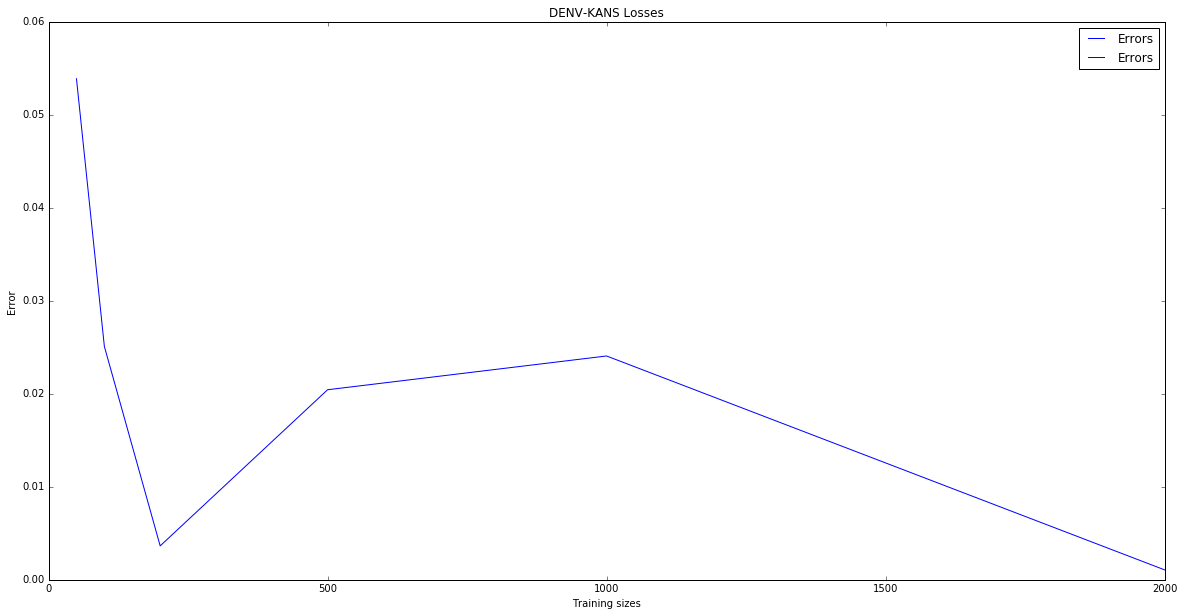

In [495]:
fig1_errors = plt.figure(figsize=(20,10))
plt.plot(training_sizes, errors_denvkans, color='blue',label='Errors', linewidth=1)
plt.xlabel("Training sizes")
plt.ylabel("Error")
plt.legend(loc='best')
plt.title('DENV-KANS Losses')
plt.show()

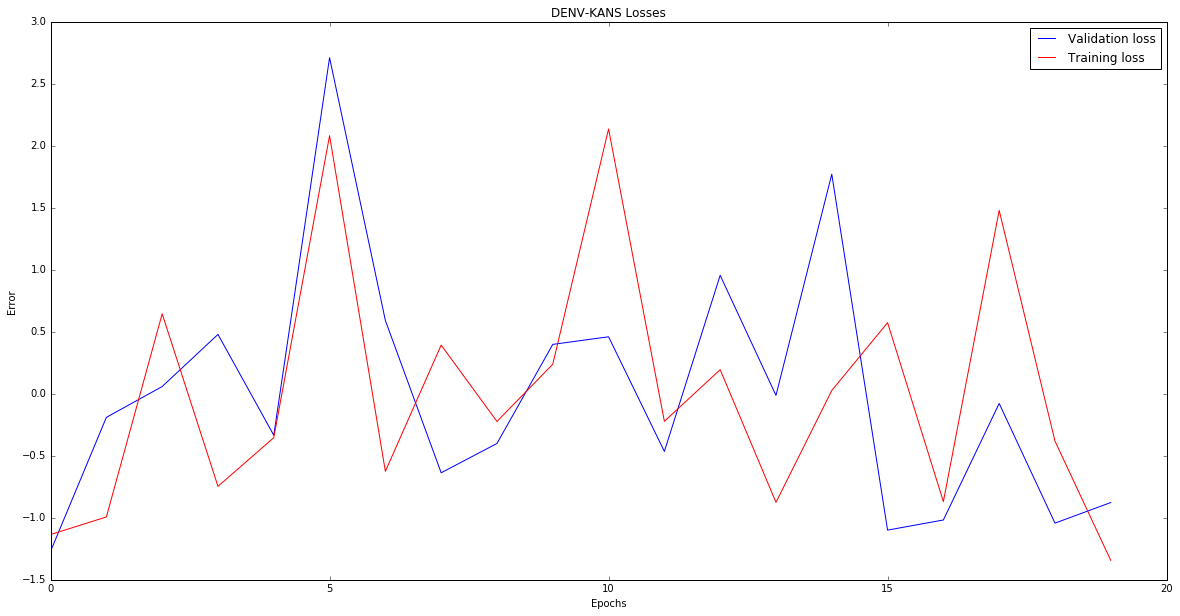

In [520]:
val_loss_reshaped_denvkans = np.array(val_loss_denvkans).reshape(np.array(val_loss_denvkans).shape[0])
train_loss_reshaped_denvkans = np.array(train_loss_denvkans).reshape(np.array(train_loss_denvkans).shape[0])

losses_denvkans = pd.DataFrame()
losses_denvkans['Train loss'] = train_loss_reshaped_denvkans
losses_denvkans['Validation loss'] = val_loss_reshaped_denvkans

losses_norm_denvkans = (losses_denvkans - losses_denvkans.mean()) / (losses_denvkans.std())

fig1_losses = plt.figure(figsize=(20,10))
plt.plot(losses_norm_denvkans['Validation loss'], color='blue',label='Validation loss', linewidth=1)
plt.plot(losses_norm_denvkans['Train loss'], color='red',label='Training loss', linewidth=1)
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend(loc='best')
plt.title('DENV-KANS Losses')
plt.show()

Test loss: 0.0010961885755


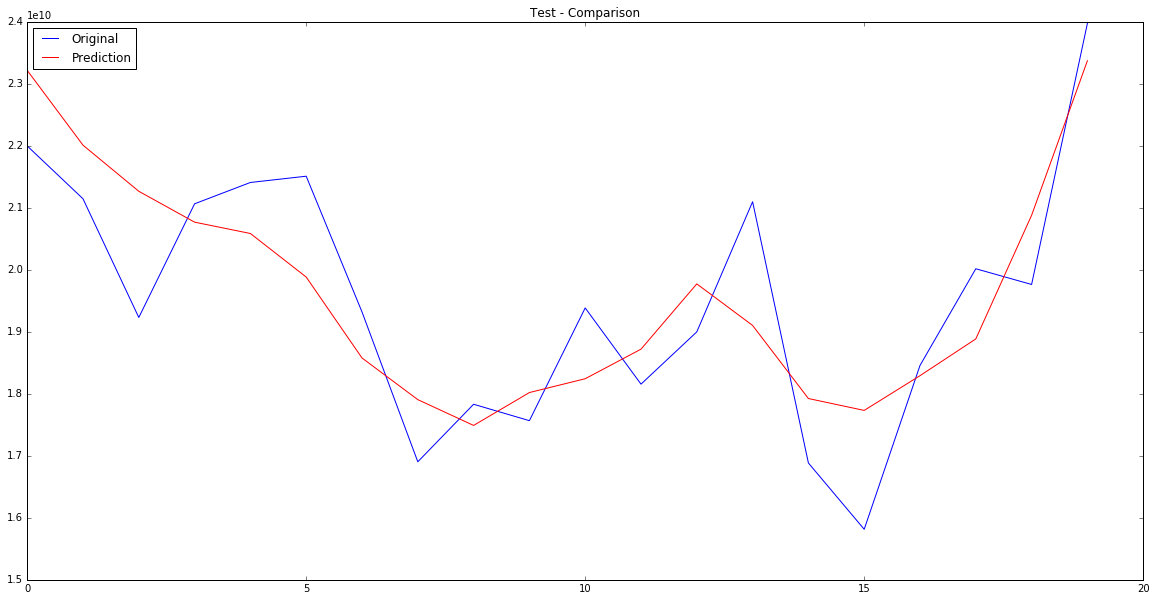

In [245]:
score = model_denvkans.evaluate(X_val_denvkans, Y_val_denvkans, verbose=0, batch_size = 1)
print('Test loss:', score)

graph_results(model_denvkans, X_val_denvkans, Y_val_denvkans, traffic_scaler)

In [521]:
total_truth_denvkans, total_pred_denvkans = train_val_predictions(model_denvkans, X_train_denvkans, Y_train_denvkans, 
                                                                 X_val_denvkans, Y_val_denvkans)

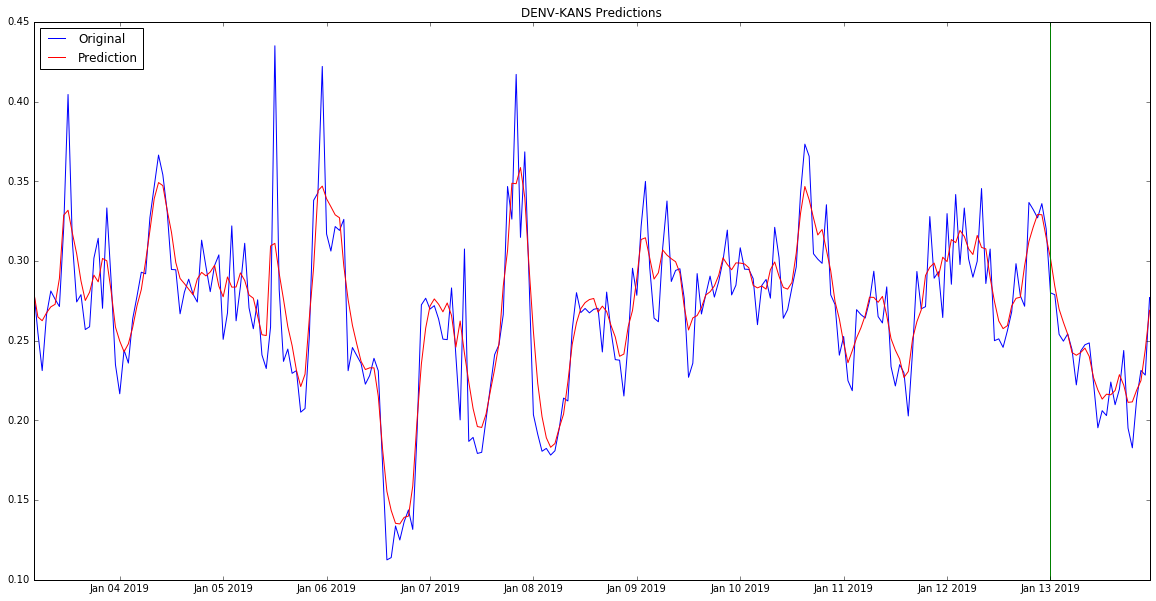

In [523]:
#control how much training data to show
x = 1900

# walk-forward validation on the test data
line_test_pred = np.reshape(total_pred_denvkans[x:], total_pred_denvkans[x:].shape[0])
line_test_real = np.reshape(total_truth_denvkans[x:], total_truth_denvkans[x:].shape[0])

#dates for plot
#dates = df_denv_kans['Time'].apply(lambda x: datetime.fromtimestamp(x/1000.))
dates = df_denv_kans['Time'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

fig1 = plt.figure(figsize=(20,10))
plt.plot(dates[x:], 
         line_test_real, color='blue',label='Original', linewidth=1)
plt.plot(dates[x:], 
         line_test_pred, color='red',label='Prediction', linewidth=1)
plt.axvline(x=dates[2136], color = 'green')
plt.legend(loc='best')
plt.title('DENV-KANS Predictions')
plt.show()

fig1.savefig('time-series-prediction/denv-kans.png')

In [524]:
final_preds_denvkans_df = pd.DataFrame()
final_preds_denvkans_df['Time'] = dates[2136:]
final_preds_denvkans_df['In Prediction'] = total_pred_denvkans[2136:]
final_preds_denvkans_df.to_csv('time-series-prediction/denv_kans_pred.csv', sep=',')

# STAR-AOFA

In [496]:
scaler = MinMaxScaler(feature_range=(0,1))
traffic_scaler = MinMaxScaler(feature_range=(0,1))
scaler, traffic_scaler, X_train_staraofa, Y_train_staraofa, X_val_staraofa, Y_val_staraofa = train_test_wfeatures(
    df_star_aofa[['Time', 'In']], scaler, traffic_scaler)

X_train shape:  (2136, 1, 1)
Y_train shape:  (2136, 1)
X_val shape:  (24, 1, 1)
Y_val shape:  (24, 1)


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.w

In [497]:
nb_epoch = 20
batch_size = 1

train_loss_staraofa = []
val_loss_staraofa = []

training_sizes = [50, 100, 200, 500, 1000, 2000]
errors_staraofa = []

for train_size in training_sizes:
    
    #creating
    model_staraofa = Sequential()
    model_staraofa.add(LSTM(50, batch_input_shape=(batch_size, 
                                                   X_train_staraofa.shape[1], 
                                                   X_train_staraofa.shape[2]), 
                                                    stateful=True))
    model_staraofa.add(Dense(1))
    
    #building
    model_staraofa.compile(loss="mse",
                      optimizer = 'adam',
                    metrics = ['accuracy'])

    #training
    for i in range(nb_epoch):
        history = model_staraofa.fit(X_train_staraofa[:x], Y_train_staraofa[:x], nb_epoch=1, 
                                     batch_size=batch_size, shuffle=False, 
                                     validation_data = (X_val_staraofa, Y_val_staraofa), verbose = 0)
        model_staraofa.reset_states()
        
    error = model_staraofa.evaluate(X_train_staraofa[train_size + 1].reshape(1,1,1), 
                                    Y_train_staraofa[train_size + 1].reshape(1,1), 
                                    verbose=0, batch_size = 1)
    errors_staraofa.append(error)

for i in range(nb_epoch):
    
    #creating
    model_staraofa = Sequential()
    model_staraofa.add(LSTM(50, batch_input_shape=(batch_size, 
                                                   X_train_staraofa.shape[1], 
                                                   X_train_staraofa.shape[2]), 
                                                    stateful=True))
    model_staraofa.add(Dense(1))
    
    #building
    model_staraofa.compile(loss="mse",
                      optimizer = 'adam',
                    metrics = ['accuracy'])

    #training
    history = model_staraofa.fit(X_train_staraofa, Y_train_staraofa, nb_epoch=1, 
                                 batch_size=batch_size, shuffle=False, 
                                 validation_data = (X_val_staraofa, Y_val_staraofa), verbose = 0)
    train_loss_staraofa.append(history.history['loss'])
    val_loss_staraofa.append(history.history['val_loss'])
    model_staraofa.reset_states()

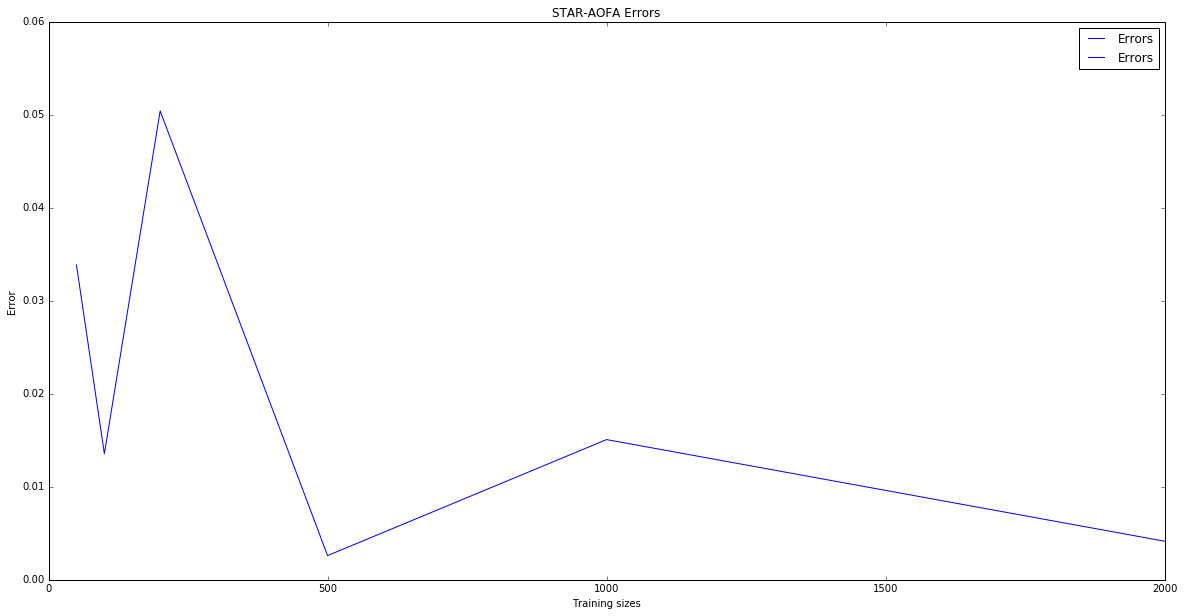

In [498]:
fig1_errors = plt.figure(figsize=(20,10))
plt.plot(training_sizes, errors_staraofa, color='blue',label='Errors', linewidth=1)
plt.xlabel("Training sizes")
plt.ylabel("Error")
plt.legend(loc='best')
plt.title('STAR-AOFA Errors')
plt.show()

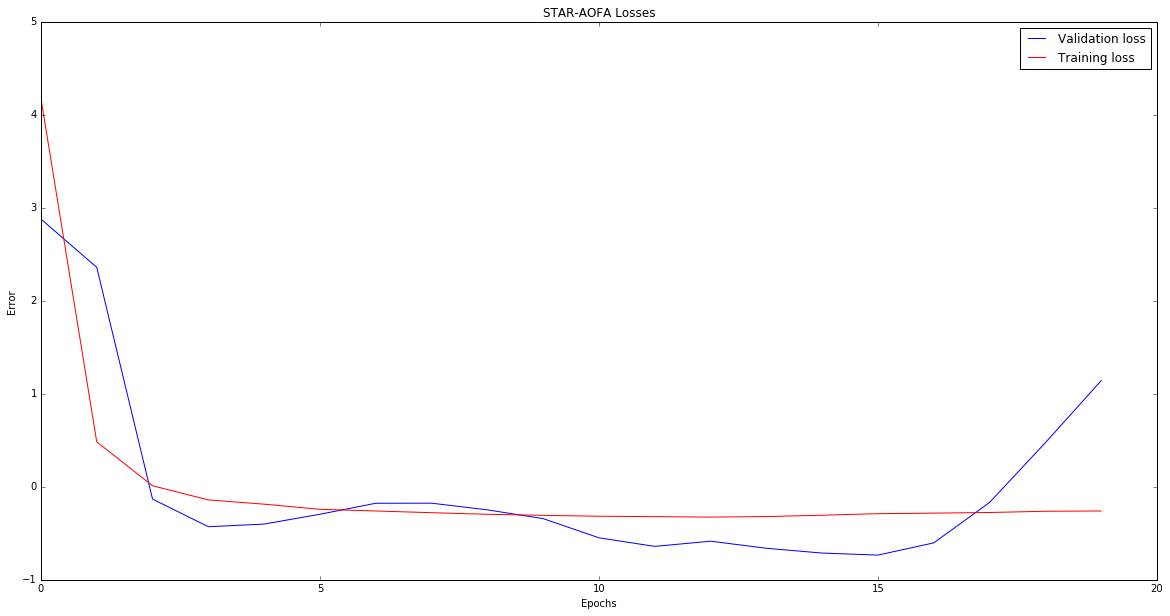

In [436]:
val_loss_reshaped_staraofa = np.array(val_loss_staraofa).reshape(np.array(val_loss_staraofa).shape[0])
train_loss_reshaped_staraofa = np.array(train_loss_staraofa).reshape(np.array(train_loss_staraofa).shape[0])

losses_staraofa = pd.DataFrame()
losses_staraofa['Train loss'] = train_loss_reshaped_staraofa
losses_staraofa['Validation loss'] = val_loss_reshaped_staraofa

losses_norm_staraofa = (losses_staraofa - losses_staraofa.mean()) / (losses_staraofa.std())

fig1_losses = plt.figure(figsize=(20,10))
plt.plot(losses_norm_staraofa['Validation loss'], color='blue',label='Validation loss', linewidth=1)
plt.plot(losses_norm_staraofa['Train loss'], color='red',label='Training loss', linewidth=1)
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend(loc='best')
plt.title('STAR-AOFA Losses')
plt.show()

Test loss: 0.0135693468377


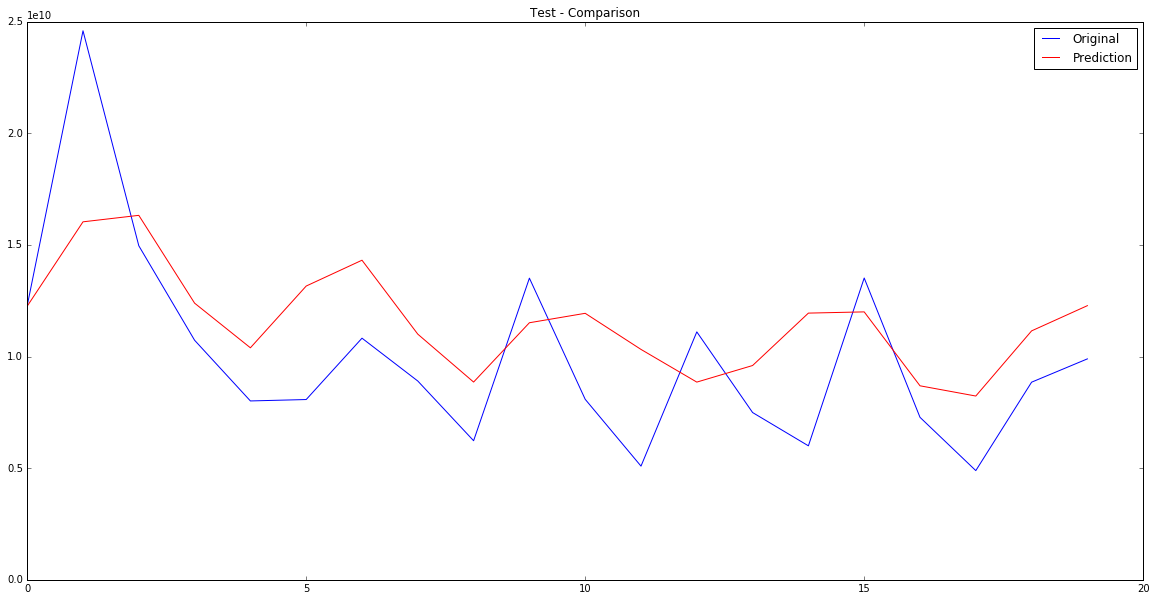

In [280]:
score = model_staraofa.evaluate(X_val_staraofa, Y_val_staraofa, verbose=0, batch_size = 1)
print('Test loss:', score)

graph_results(model_staraofa, X_val_staraofa, Y_val_staraofa, traffic_scaler)

In [525]:
total_truth_staraofa, total_pred_staraofa = train_val_predictions(model_staraofa, X_train_staraofa, Y_train_staraofa, 
                                                                 X_val_staraofa, Y_val_staraofa)

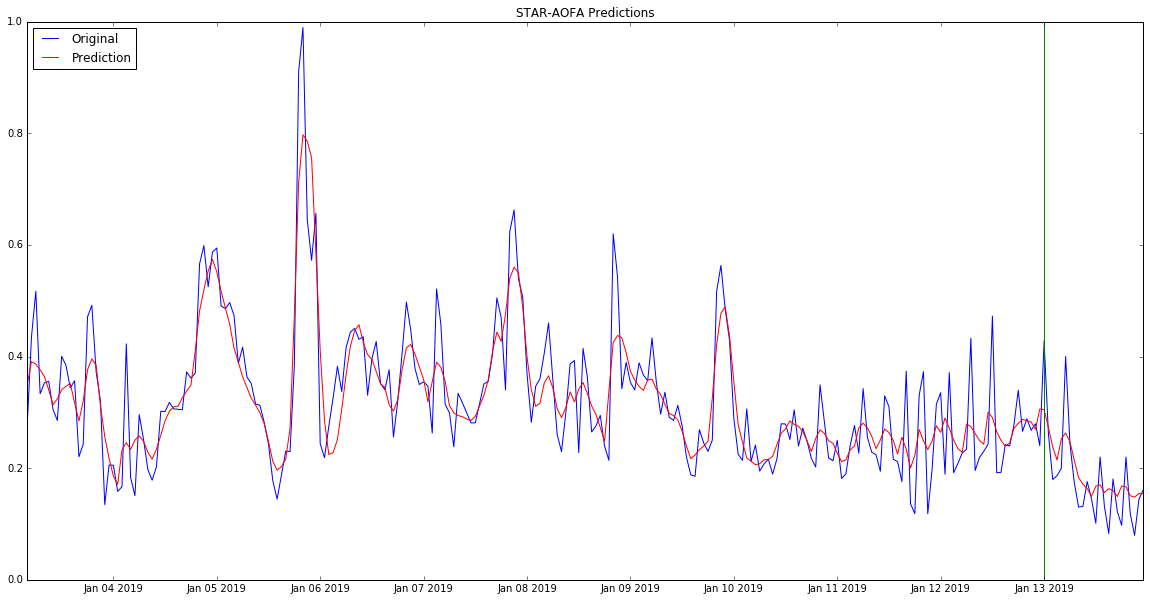

In [527]:
#control how much training data to show
x = 1900

# walk-forward validation on the test data
line_test_pred = np.reshape(total_pred_staraofa[x:], total_pred_staraofa[x:].shape[0])
line_test_real = np.reshape(total_truth_staraofa[x:], total_truth_staraofa[x:].shape[0])

#dates for plot
#dates = df_star_aofa['Time'].apply(lambda x: datetime.fromtimestamp(x/1000.))
dates = df_star_aofa['Time'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

fig1 = plt.figure(figsize=(20,10))
plt.plot(dates[x:], 
         line_test_real, color='blue',label='Original', linewidth=1)
plt.plot(dates[x:], 
         line_test_pred, color='red',label='Prediction', linewidth=1)
plt.axvline(x=dates[2136], color = 'green')
plt.legend(loc='best')
plt.title('STAR-AOFA Predictions')
plt.show()

fig1.savefig('time-series-prediction/star-aofa.png')

In [528]:
final_preds_staraofa_df = pd.DataFrame()
final_preds_staraofa_df['Time'] = dates[2136:]
final_preds_staraofa_df['In Prediction'] = total_pred_staraofa[2136:]
final_preds_staraofa_df.to_csv('time-series-prediction/star_aofa_pred.csv', sep=',')

# AOFA-LOND

In [535]:
scaler = MinMaxScaler(feature_range=(0,1))
traffic_scaler = MinMaxScaler(feature_range=(0,1))
scaler, traffic_scaler, X_train_aofalond, Y_train_aofalond, X_val_aofalond, Y_val_aofalond = train_test_wfeatures(
    df_aofa_lond[['Time', 'Out']], scaler, traffic_scaler)

X_train shape:  (2136, 1, 1)
Y_train shape:  (2136, 1)
X_val shape:  (24, 1, 1)
Y_val shape:  (24, 1)


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.w

In [536]:
nb_epoch = 20
batch_size = 1

train_loss_aofalond = []
val_loss_aofalond = []

training_sizes = [50, 100, 200, 500, 1000, 2000]
errors_aofalond = []

for train_size in training_sizes:
    
    #creating
    model_aofalond = Sequential()
    model_aofalond.add(LSTM(50, batch_input_shape=(batch_size, 
                                                   X_train_aofalond.shape[1], 
                                                   X_train_aofalond.shape[2]), 
                                                    stateful=True))
    model_aofalond.add(Dense(1))
    
    #building
    model_aofalond.compile(loss="mse",
                      optimizer = 'adam',
                    metrics = ['accuracy'])

    #training
    for i in range(nb_epoch):
        history = model_aofalond.fit(X_train_aofalond[:x], Y_train_aofalond[:x], nb_epoch=1, 
                                     batch_size=batch_size, shuffle=False, 
                                     validation_data = (X_val_aofalond, Y_val_aofalond), verbose = 0)
        model_aofalond.reset_states()
        
    error = model_aofalond.evaluate(X_train_aofalond[train_size + 1].reshape(1,1,1), 
                                    Y_train_aofalond[train_size + 1].reshape(1,1), 
                                    verbose=0, batch_size = 1)
    errors_aofalond.append(error)

for i in range(nb_epoch):
    
    #creating
    model_aofalond = Sequential()
    model_aofalond.add(LSTM(50, batch_input_shape=(batch_size, 
                                                   X_train_aofalond.shape[1], 
                                                   X_train_aofalond.shape[2]), 
                                                    stateful=True))
    model_aofalond.add(Dense(1))
    
    #building
    model_aofalond.compile(loss="mse",
                      optimizer = 'adam',
                    metrics = ['accuracy'])

    #training
    history = model_aofalond.fit(X_train_aofalond, Y_train_aofalond, nb_epoch=1, 
                                     batch_size=batch_size, shuffle=False, 
                                     validation_data = (X_val_aofalond, Y_val_aofalond), verbose = 0)
    train_loss_aofalond.append(history.history['loss'])
    val_loss_aofalond.append(history.history['val_loss'])
    model_aofalond.reset_states()

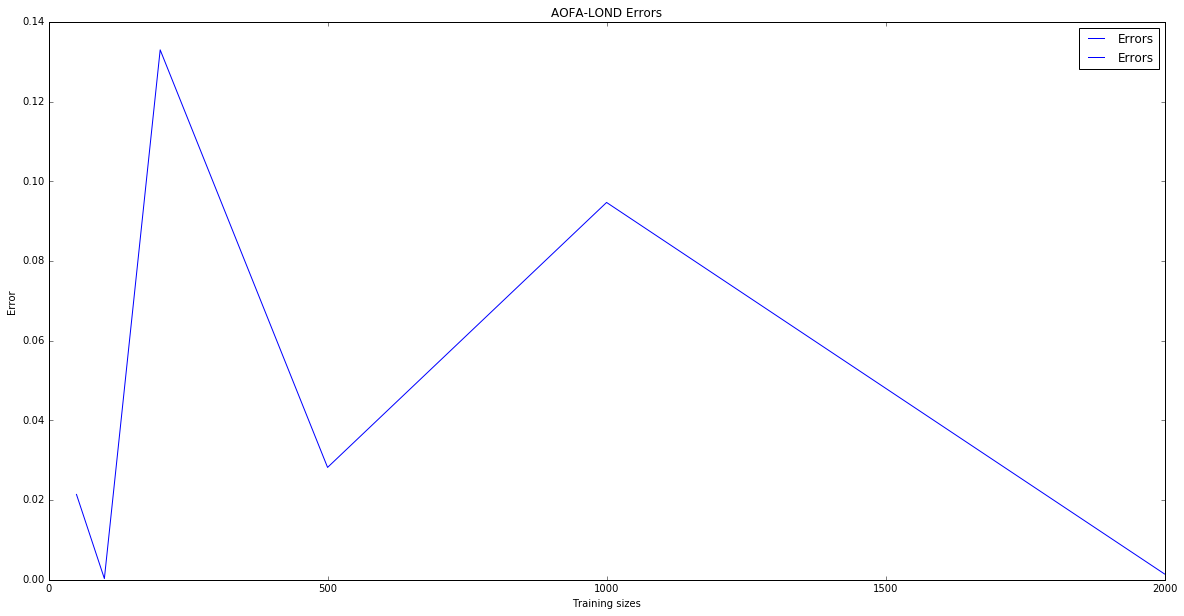

In [500]:
fig1_errors = plt.figure(figsize=(20,10))
plt.plot(training_sizes, errors_aofalond, color='blue',label='Errors', linewidth=1)
plt.xlabel("Training sizes")
plt.ylabel("Error")
plt.legend(loc='best')
plt.title('AOFA-LOND Errors')
plt.show()

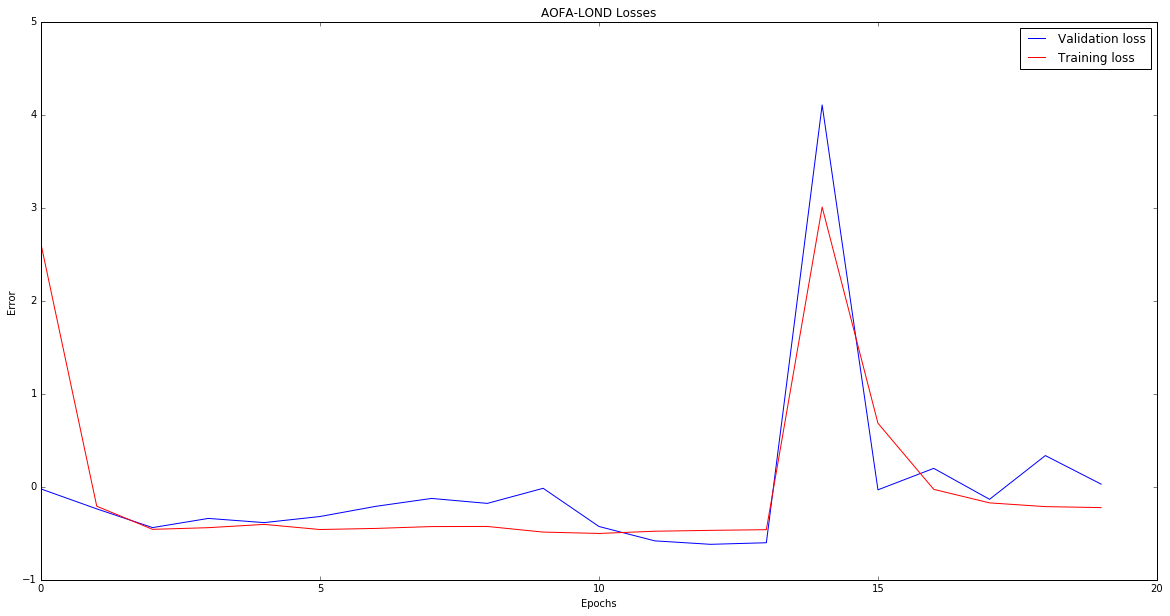

In [450]:
val_loss_reshaped_aofalond = np.array(val_loss_aofalond).reshape(np.array(val_loss_aofalond).shape[0])
train_loss_reshaped_aofalond = np.array(train_loss_aofalond).reshape(np.array(train_loss_aofalond).shape[0])

losses_aofalond = pd.DataFrame()
losses_aofalond['Train loss'] = train_loss_reshaped_aofalond
losses_aofalond['Validation loss'] = val_loss_reshaped_aofalond

losses_norm_aofalond = (losses_aofalond - losses_aofalond.mean()) / (losses_aofalond.std())

fig1_losses = plt.figure(figsize=(20,10))
plt.plot(losses_norm_aofalond['Validation loss'], color='blue',label='Validation loss', linewidth=1)
plt.plot(losses_norm_aofalond['Train loss'], color='red',label='Training loss', linewidth=1)
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend(loc='best')
plt.title('AOFA-LOND Losses')
plt.show()

Test loss: 0.115490203039


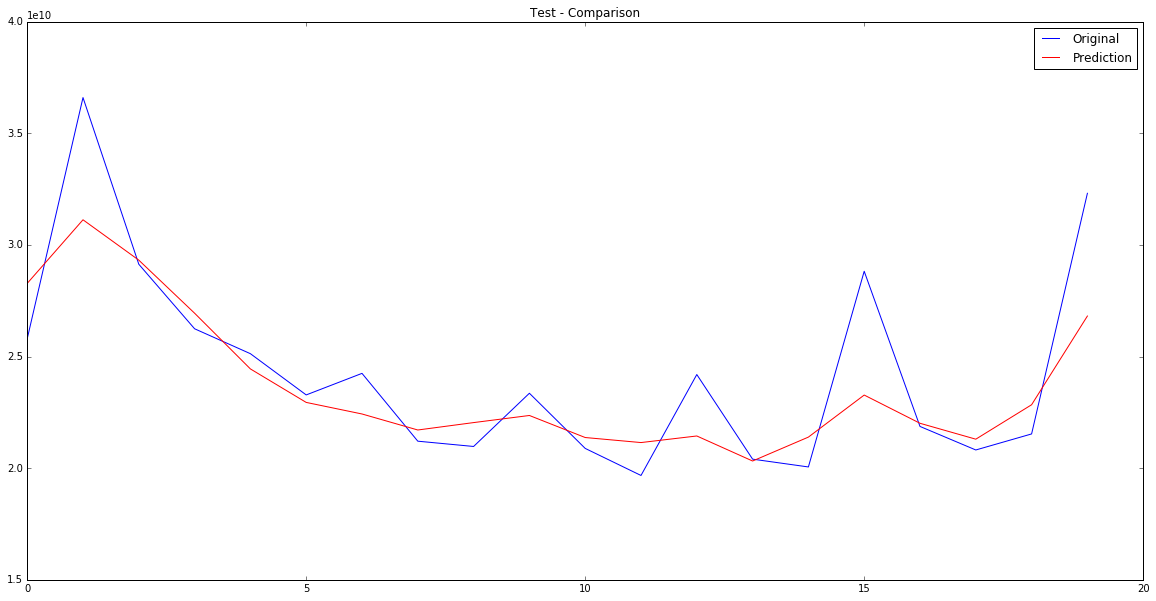

In [287]:
score = model_aofalond.evaluate(X_val_aofalond, Y_val_aofalond, verbose=0, batch_size = 1)
print('Test loss:', score)

graph_results(model_aofalond, X_val_aofalond, Y_val_aofalond, traffic_scaler)

In [537]:
total_truth_aofalond, total_pred_aofalond = train_val_predictions(model_aofalond, X_train_aofalond, Y_train_aofalond, 
                                                                 X_val_aofalond, Y_val_aofalond)

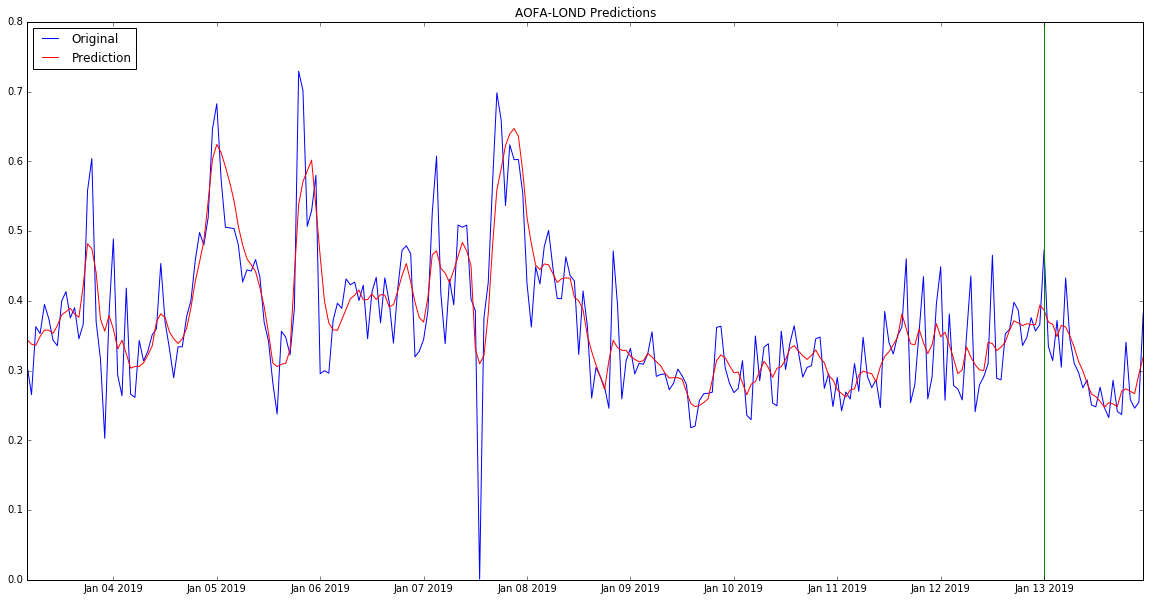

In [539]:
#control how much training data to show
x = 1900

# walk-forward validation on the test data
line_test_pred = np.reshape(total_pred_aofalond[x:], total_pred_aofalond[x:].shape[0])
line_test_real = np.reshape(total_truth_aofalond[x:], total_truth_aofalond[x:].shape[0])

#dates for plot
#dates = df_aofa_lond['Time'].apply(lambda x: datetime.fromtimestamp(x/1000.))
dates = df_aofa_lond['Time'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

fig1 = plt.figure(figsize=(20,10))
plt.plot(dates[x:], 
         line_test_real, color='blue',label='Original', linewidth=1)
plt.plot(dates[x:], 
         line_test_pred, color='red',label='Prediction', linewidth=1)
plt.axvline(x=dates[2136], color = 'green')
plt.legend(loc='best')
plt.title('AOFA-LOND Predictions')
plt.show()

fig1.savefig('time-series-prediction/aofa-lond.png')

In [290]:
final_preds_aofalond_df = pd.DataFrame()
final_preds_aofalond_df['Time'] = dates[2136:]
final_preds_aofalond_df['In Prediction'] = total_pred_staraofa[2136:]
final_preds_aofalond_df.to_csv('time-series-prediction/star_aofa_pred.csv', sep=',')

# Results

In [361]:
results = pd.DataFrame()
results['Hour'] = [1, 4, 8, 16]

hr1_error = (abs(total_pred_sacrdenv[2136] - total_pred_sacrdenv[2136]) 
                + abs(total_pred_denvkans[2136] - total_truth_denvkans[2136])
                + abs(total_pred_staraofa[2136] - total_truth_staraofa[2136])
                + abs(total_pred_aofalond[2136] - total_truth_aofalond[2136]))/4

hr4_error = (abs(total_pred_sacrdenv[2136 + 4] - total_pred_sacrdenv[2136+ 4]) 
                + abs(total_pred_denvkans[2136+ 4] - total_truth_denvkans[2136+ 4])
                + abs(total_pred_staraofa[2136+ 4] - total_truth_staraofa[2136+ 4])
                + abs(total_pred_aofalond[2136+ 4] - total_truth_aofalond[2136+ 4]))/4

hr8_error = (abs(total_pred_sacrdenv[2136+ 8] - total_pred_sacrdenv[2136+ 8]) 
                + abs(total_pred_denvkans[2136+ 8] - total_truth_denvkans[2136+ 8])
                + abs(total_pred_staraofa[2136+ 8] - total_truth_staraofa[2136+ 8])
                + abs(total_pred_aofalond[2136+ 8] - total_truth_aofalond[2136+ 8]))/4

hr16_error = (abs(total_pred_sacrdenv[2136 + 16] - total_pred_sacrdenv[2136+ 16]) 
                + abs(total_pred_denvkans[2136+ 16] - total_truth_denvkans[2136+ 16])
                + abs(total_pred_staraofa[2136+ 16] - total_truth_staraofa[2136+ 16])
                + abs(total_pred_aofalond[2136+ 16] - total_truth_aofalond[2136+ 16]))/4

results['Error'] = [hr1_error[0], 
                   hr4_error[0], 
                   hr8_error[0], 
                   hr16_error[0]]
results

,Hour,Error
0,1,0.035301
1,4,0.017404
2,8,0.014675
3,16,0.005438


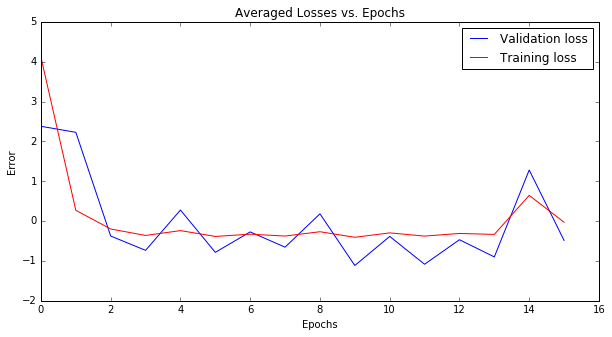

In [459]:
averaged_losses = pd.DataFrame()
averaged_losses['Train loss average'] = (losses_norm_sacrdenv['Train loss'] 
                                            + losses_norm_denvkans['Train loss']
                                            + losses_norm_staraofa['Train loss']
                                            + losses_norm_aofalond['Train loss'])/4
averaged_losses['Validation loss average'] = (losses_norm_sacrdenv['Validation loss'] 
                                            + losses_norm_denvkans['Validation loss']
                                            + losses_norm_staraofa['Validation loss']
                                            + losses_norm_aofalond['Validation loss'])/4

averaged_losses_norm = (averaged_losses - averaged_losses.mean()) / (averaged_losses.std())

fig1_losses = plt.figure(figsize=(10,5))
plt.plot(averaged_losses_norm['Validation loss average'][:16], color='blue',label='Validation loss', linewidth=1)
plt.plot(averaged_losses_norm['Train loss average'][:16], color='red',label='Training loss', linewidth=1)
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend(loc='best')
plt.title('Averaged Losses vs. Epochs')
plt.show()

fig1_losses.savefig('time-series-prediction/errors-vs-epochs.png')

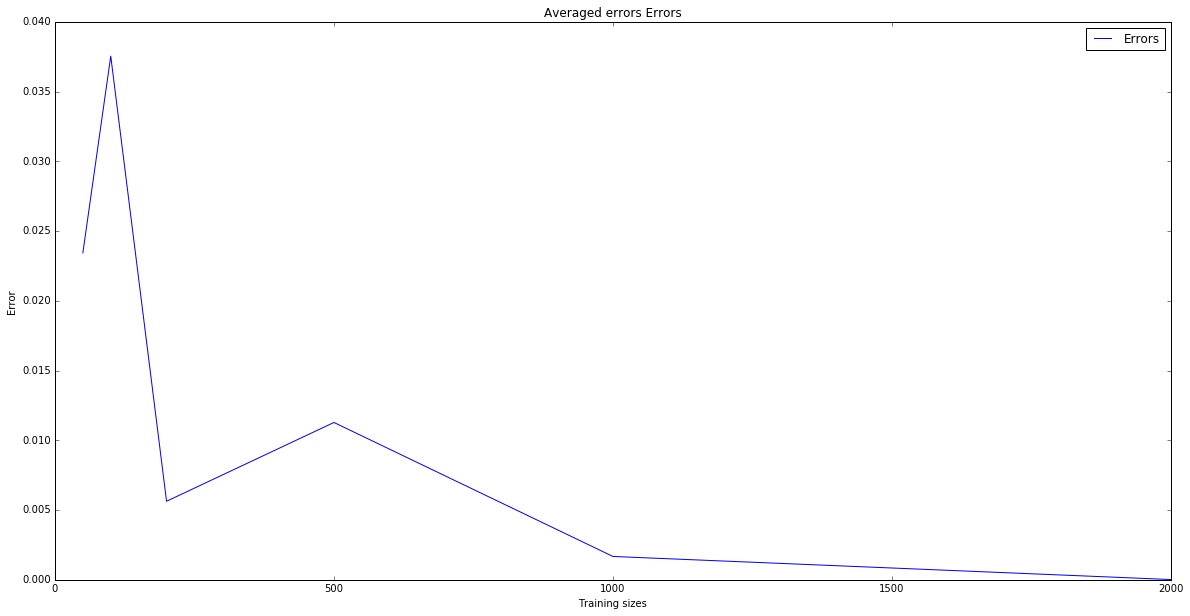

In [509]:
zipped_list = zip(errors_sacrdenv, errors_denvkans, errors_staraofa, errors_aofalond)

sum_errors = [sum(item[0]) for item in zipped_list]
averaged_errors = [item/4 for item in sum_errors]

fig1_errors = plt.figure(figsize=(20,10))
plt.plot(training_sizes, sum_errors, color='blue',label='Errors', linewidth=1)
plt.xlabel("Training sizes")
plt.ylabel("Error")
plt.legend(loc='best')
plt.title('Averaged errors Errors')
plt.show()

fig1_errors.savefig('time-series-prediction/error-vs-training-sizes.png')